In [1]:
import time

import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras

In [2]:
(train_x, _), _ = keras.datasets.mnist.load_data()

In [3]:
print(f'Images shape: {train_x.shape}')

Images shape: (60000, 28, 28)


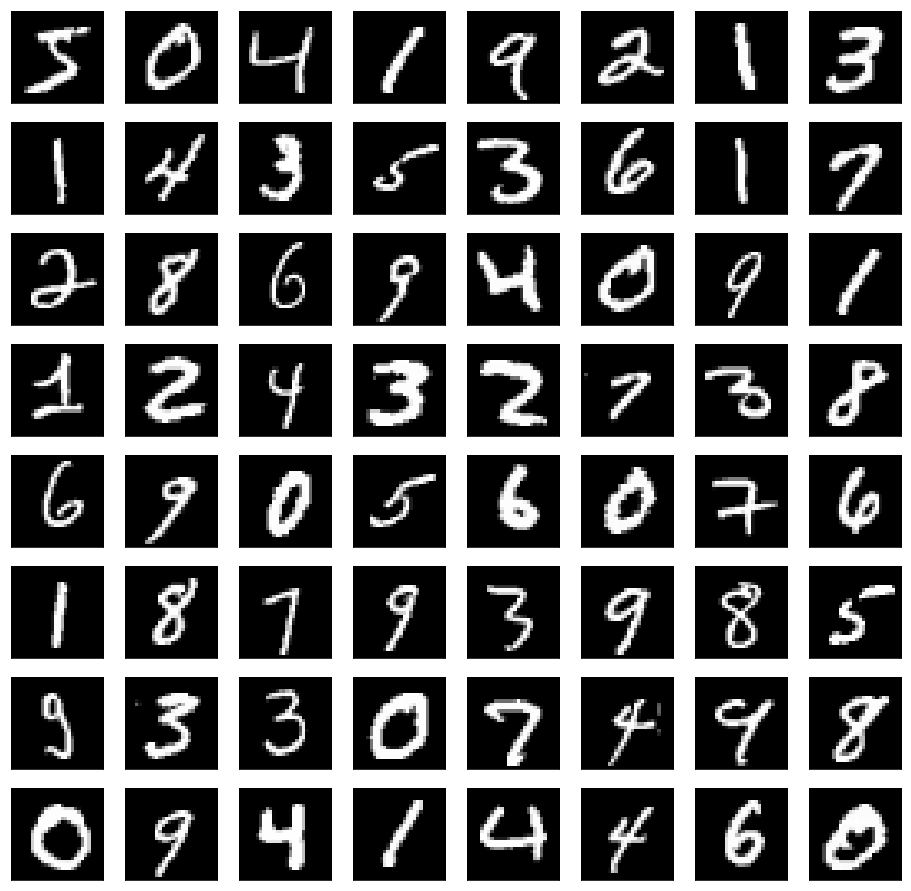

In [4]:
plt.figure(figsize=(16, 16))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(train_x[i], cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [5]:
train_x = train_x.astype(np.float32) / 127.5 - 1

In [6]:
def plot_history(history):
    plt.figure(figsize=(16, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['epoch'], history['d_loss'], label='discriminator loss')
    plt.plot(history['epoch'], history['g_loss'], label='generator loss')
    plt.title('Visualization of loss during training')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(history['epoch'], history['d_acc'], label='discriminator accuracy')
    plt.title('Visualization of accuracy during training')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

    plt.show()

In [7]:
generator = keras.Sequential([
    keras.layers.Dense(250, input_shape=(100,)),
    keras.layers.LeakyReLU(0.2),
    keras.layers.BatchNormalization(momentum=0.8),
    keras.layers.Dense(500),
    keras.layers.LeakyReLU(0.2),
    keras.layers.BatchNormalization(momentum=0.8),
    keras.layers.Dense(1000),
    keras.layers.LeakyReLU(0.2),
    keras.layers.BatchNormalization(momentum=0.8),
    keras.layers.Dense(784, activation='tanh'),
    keras.layers.Reshape((28, 28))])
generator.compile(
    optimizer=keras.optimizers.Adam(),
    loss='binary_crossentropy')
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 250)               25250     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 250)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 250)               1000      
_________________________________________________________________
dense_1 (Dense)              (None, 500)               125500    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 500)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2000      
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              501000    
__________

In [8]:
discriminator = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(500),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(250),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')])
discriminator.compile(
    optimizer=keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy'])
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               392500    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 500)               0         
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               125250    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 250)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
__________

In [9]:
discriminator.trainable = False
inputs = keras.layers.Input(shape=(100,))
outputs = discriminator(generator(inputs))

combined = keras.Model(inputs=inputs, outputs=outputs)
combined.compile(
    optimizer=keras.optimizers.Adam(),
    loss='binary_crossentropy')
combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28)            1443534   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 518001    
Total params: 1,961,535
Trainable params: 1,440,034
Non-trainable params: 521,501
_________________________________________________________________


In [10]:
def train(images, batch_size=32, epochs=1):
    history = {'epoch': [], 'g_loss': [], 'd_loss': [], 'd_acc': []}
    batch_n = int(images.shape[0] / batch_size)

    for epoch in range(0, epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        start_time = time.time()

        d_loss, g_loss, d_acc = 0, 0, 0
        for _ in range(batch_n):
            real_images = images[np.random.randint(0, images.shape[0], batch_size)]
            generated_images = generator.predict(np.random.normal(0, 1, (batch_size, 100)))
            # Train discriminator
            x = np.vstack([real_images, generated_images])
            y = np.hstack([np.ones(batch_size), np.zeros(batch_size)])
            discriminator.trainable = True
            d_loss_batch, d_acc_batch = discriminator.train_on_batch(x, y)
            d_loss += d_loss_batch
            d_acc += d_acc_batch
            # Train generator
            x = np.random.normal(0, 1, size=(batch_size, 100))
            y = np.ones(batch_size)
            discriminator.trainable = False
            g_loss += combined.train_on_batch(x, y)

        d_loss /= batch_n
        d_acc /= batch_n
        g_loss /= batch_n
        history['epoch'].append(epoch)
        history['g_loss'].append(g_loss)
        history['d_loss'].append(d_loss)
        history['d_acc'].append(d_acc)

        dur = time.time() - start_time
        print(f' - {dur:.0f}s - g_loss: {g_loss:.4f} - d_loss: {d_loss:.4f} - d_acc: {d_acc:.4f}')
        
        if epoch == 0 or (epoch + 1) % 20 == 0 or epoch + 1 == epochs:
            generated_images = generator.predict(
                np.random.normal(0, 1, size=(24, 100)))
            plt.figure(figsize=(16, 6))
            for i in range(24):
                plt.subplot(3, 8, i + 1)
                plt.imshow(generated_images[i], cmap=plt.cm.gray)
                plt.xticks([])
                plt.yticks([])
            plt.show()
            
    return history

Epoch 1/400
 - 63s - g_loss: 12.1359 - d_loss: 0.0551 - d_acc: 0.9810


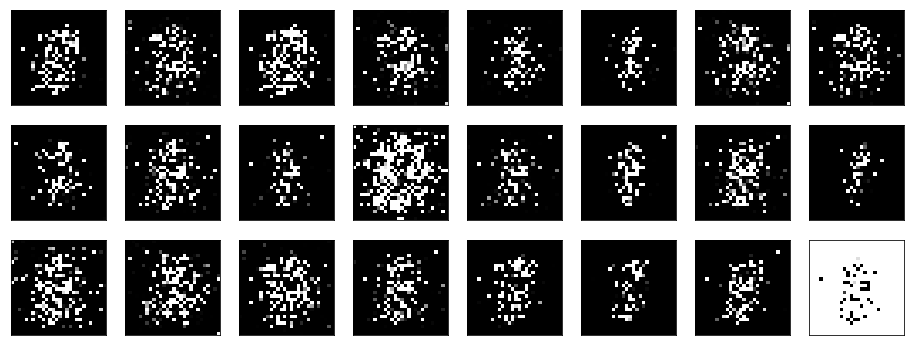

Epoch 2/400
 - 60s - g_loss: 9.7301 - d_loss: 0.0702 - d_acc: 0.9739
Epoch 3/400
 - 60s - g_loss: 7.7269 - d_loss: 0.1018 - d_acc: 0.9620
Epoch 4/400
 - 62s - g_loss: 7.5935 - d_loss: 0.1045 - d_acc: 0.9606
Epoch 5/400
 - 62s - g_loss: 6.9982 - d_loss: 0.1293 - d_acc: 0.9505
Epoch 6/400
 - 60s - g_loss: 6.4406 - d_loss: 0.1668 - d_acc: 0.9337
Epoch 7/400
 - 61s - g_loss: 5.5761 - d_loss: 0.2271 - d_acc: 0.9073
Epoch 8/400
 - 61s - g_loss: 4.4189 - d_loss: 0.3057 - d_acc: 0.8705
Epoch 9/400
 - 60s - g_loss: 4.0487 - d_loss: 0.3491 - d_acc: 0.8493
Epoch 10/400
 - 60s - g_loss: 4.2458 - d_loss: 0.3416 - d_acc: 0.8515
Epoch 11/400
 - 60s - g_loss: 3.9051 - d_loss: 0.3805 - d_acc: 0.8342
Epoch 12/400
 - 61s - g_loss: 3.9073 - d_loss: 0.3817 - d_acc: 0.8337
Epoch 13/400
 - 61s - g_loss: 3.9871 - d_loss: 0.3898 - d_acc: 0.8285
Epoch 14/400
 - 61s - g_loss: 4.4464 - d_loss: 0.3664 - d_acc: 0.8393
Epoch 15/400
 - 60s - g_loss: 3.9875 - d_loss: 0.3959 - d_acc: 0.8271
Epoch 16/400
 - 60s - g_loss

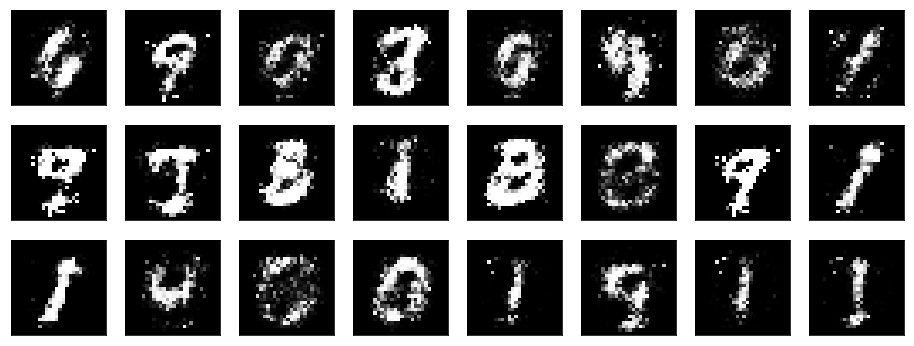

Epoch 21/400
 - 60s - g_loss: 2.7770 - d_loss: 0.5107 - d_acc: 0.7604
Epoch 22/400
 - 61s - g_loss: 2.9408 - d_loss: 0.5046 - d_acc: 0.7670
Epoch 23/400
 - 60s - g_loss: 2.7539 - d_loss: 0.5232 - d_acc: 0.7556
Epoch 24/400
 - 61s - g_loss: 2.7481 - d_loss: 0.5236 - d_acc: 0.7558
Epoch 25/400
 - 60s - g_loss: 2.6605 - d_loss: 0.5245 - d_acc: 0.7551
Epoch 26/400
 - 61s - g_loss: 2.4754 - d_loss: 0.5336 - d_acc: 0.7463
Epoch 27/400
 - 60s - g_loss: 2.5481 - d_loss: 0.5412 - d_acc: 0.7439
Epoch 28/400
 - 60s - g_loss: 2.4359 - d_loss: 0.5519 - d_acc: 0.7349
Epoch 29/400
 - 60s - g_loss: 2.3684 - d_loss: 0.5586 - d_acc: 0.7305
Epoch 30/400
 - 61s - g_loss: 2.3167 - d_loss: 0.5768 - d_acc: 0.7218
Epoch 31/400
 - 60s - g_loss: 2.1930 - d_loss: 0.5806 - d_acc: 0.7164
Epoch 32/400
 - 60s - g_loss: 2.4493 - d_loss: 0.5571 - d_acc: 0.7338
Epoch 33/400
 - 60s - g_loss: 2.3244 - d_loss: 0.5720 - d_acc: 0.7241
Epoch 34/400
 - 58s - g_loss: 2.3782 - d_loss: 0.5683 - d_acc: 0.7265
Epoch 35/400
 - 59s 

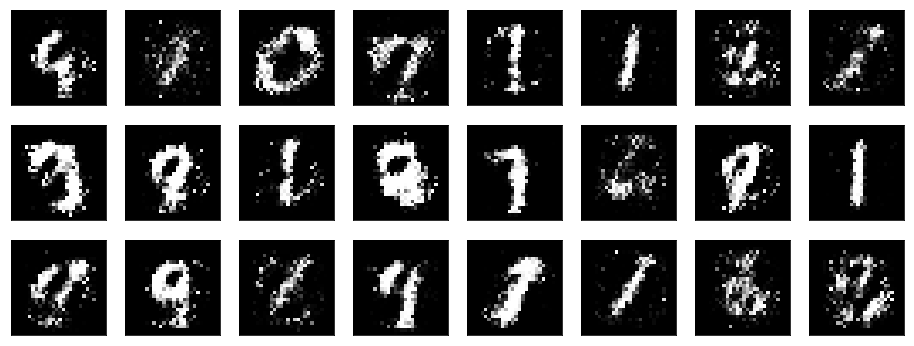

Epoch 41/400
 - 58s - g_loss: 2.1690 - d_loss: 0.6072 - d_acc: 0.7018
Epoch 42/400
 - 58s - g_loss: 2.1563 - d_loss: 0.6098 - d_acc: 0.6993
Epoch 43/400
 - 58s - g_loss: 1.9418 - d_loss: 0.6310 - d_acc: 0.6835
Epoch 44/400
 - 59s - g_loss: 2.0352 - d_loss: 0.6421 - d_acc: 0.6775
Epoch 45/400
 - 58s - g_loss: 2.0981 - d_loss: 0.6458 - d_acc: 0.6681
Epoch 46/400
 - 58s - g_loss: 2.6240 - d_loss: 0.5418 - d_acc: 0.7318
Epoch 47/400
 - 58s - g_loss: 2.0351 - d_loss: 0.6265 - d_acc: 0.6853
Epoch 48/400
 - 58s - g_loss: 2.1441 - d_loss: 0.6169 - d_acc: 0.6921
Epoch 49/400
 - 58s - g_loss: 2.0809 - d_loss: 0.6281 - d_acc: 0.6861
Epoch 50/400
 - 58s - g_loss: 2.0718 - d_loss: 0.6225 - d_acc: 0.6889
Epoch 51/400
 - 58s - g_loss: 2.2491 - d_loss: 0.5947 - d_acc: 0.7024
Epoch 52/400
 - 58s - g_loss: 2.1856 - d_loss: 0.6260 - d_acc: 0.6904
Epoch 53/400
 - 58s - g_loss: 1.9361 - d_loss: 0.6379 - d_acc: 0.6723
Epoch 54/400
 - 58s - g_loss: 2.6197 - d_loss: 0.5925 - d_acc: 0.7066
Epoch 55/400
 - 58s 

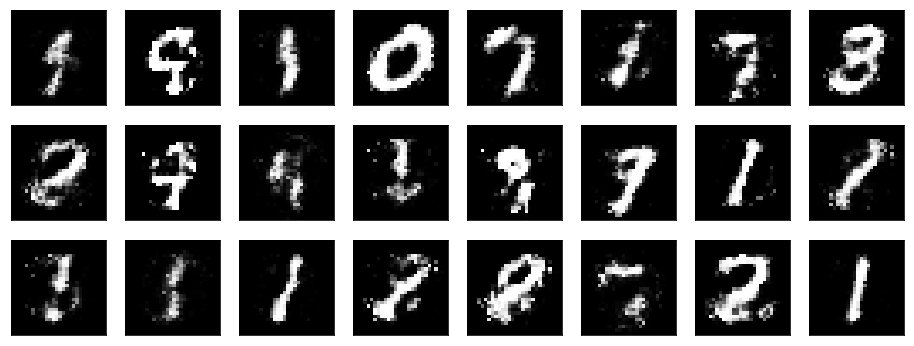

Epoch 61/400
 - 58s - g_loss: 2.5068 - d_loss: 0.6250 - d_acc: 0.6901
Epoch 62/400
 - 58s - g_loss: 2.0831 - d_loss: 0.6466 - d_acc: 0.6662
Epoch 63/400
 - 58s - g_loss: 1.9584 - d_loss: 0.6558 - d_acc: 0.6637
Epoch 64/400
 - 58s - g_loss: 2.3121 - d_loss: 0.6380 - d_acc: 0.6828
Epoch 65/400
 - 58s - g_loss: 2.1613 - d_loss: 0.6248 - d_acc: 0.6831
Epoch 66/400
 - 58s - g_loss: 1.8837 - d_loss: 0.6426 - d_acc: 0.6726
Epoch 67/400
 - 58s - g_loss: 1.7988 - d_loss: 0.6696 - d_acc: 0.6548
Epoch 68/400
 - 58s - g_loss: 1.9929 - d_loss: 0.6628 - d_acc: 0.6601
Epoch 69/400
 - 58s - g_loss: 1.9822 - d_loss: 0.6588 - d_acc: 0.6710
Epoch 70/400
 - 58s - g_loss: 1.8609 - d_loss: 0.6669 - d_acc: 0.6533
Epoch 71/400
 - 58s - g_loss: 2.2978 - d_loss: 0.6479 - d_acc: 0.6733
Epoch 72/400
 - 58s - g_loss: 1.6965 - d_loss: 0.6395 - d_acc: 0.6635
Epoch 73/400
 - 58s - g_loss: 1.8682 - d_loss: 0.6708 - d_acc: 0.6564
Epoch 74/400
 - 58s - g_loss: 2.1851 - d_loss: 0.6642 - d_acc: 0.6640
Epoch 75/400
 - 58s 

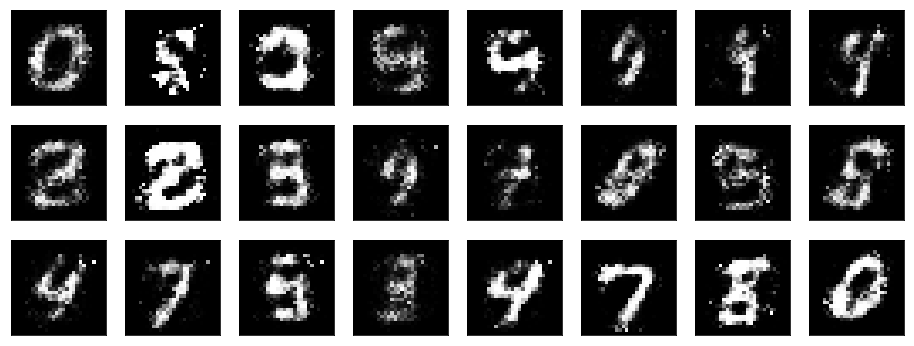

Epoch 81/400
 - 58s - g_loss: 1.8381 - d_loss: 0.6719 - d_acc: 0.6498
Epoch 82/400
 - 58s - g_loss: 2.3051 - d_loss: 0.6289 - d_acc: 0.6817
Epoch 83/400
 - 59s - g_loss: 1.9558 - d_loss: 0.6537 - d_acc: 0.6635
Epoch 84/400
 - 59s - g_loss: 2.0605 - d_loss: 0.6567 - d_acc: 0.6641
Epoch 85/400
 - 58s - g_loss: 1.9394 - d_loss: 0.6702 - d_acc: 0.6546
Epoch 86/400
 - 58s - g_loss: 1.9531 - d_loss: 0.6740 - d_acc: 0.6532
Epoch 87/400
 - 58s - g_loss: 2.0194 - d_loss: 0.6775 - d_acc: 0.6468
Epoch 88/400
 - 58s - g_loss: 1.9986 - d_loss: 0.6609 - d_acc: 0.6597
Epoch 89/400
 - 58s - g_loss: 1.6356 - d_loss: 0.6735 - d_acc: 0.6449
Epoch 90/400
 - 58s - g_loss: 1.9082 - d_loss: 0.6790 - d_acc: 0.6450
Epoch 91/400
 - 58s - g_loss: 1.5818 - d_loss: 0.6687 - d_acc: 0.6458
Epoch 92/400
 - 58s - g_loss: 1.7765 - d_loss: 0.6735 - d_acc: 0.6445
Epoch 93/400
 - 59s - g_loss: 1.8912 - d_loss: 0.6512 - d_acc: 0.6597
Epoch 94/400
 - 58s - g_loss: 2.0619 - d_loss: 0.6500 - d_acc: 0.6658
Epoch 95/400
 - 58s 

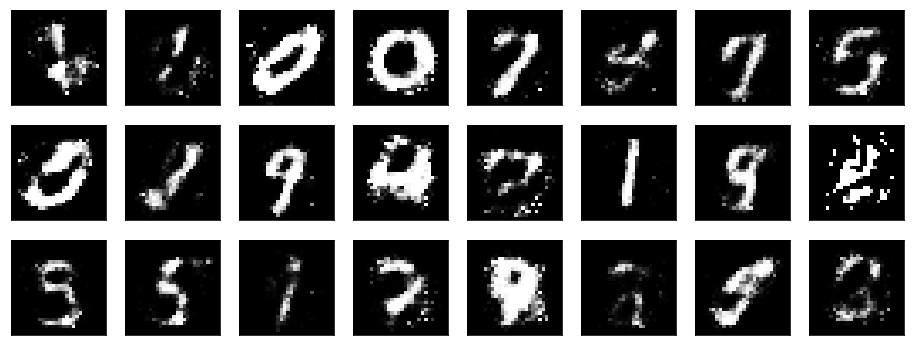

Epoch 101/400
 - 58s - g_loss: 1.8083 - d_loss: 0.6985 - d_acc: 0.6320
Epoch 102/400
 - 58s - g_loss: 1.5032 - d_loss: 0.6908 - d_acc: 0.6271
Epoch 103/400
 - 59s - g_loss: 1.6172 - d_loss: 0.6999 - d_acc: 0.6311
Epoch 104/400
 - 58s - g_loss: 2.0323 - d_loss: 0.7048 - d_acc: 0.6359
Epoch 105/400
 - 58s - g_loss: 1.7272 - d_loss: 0.6473 - d_acc: 0.6556
Epoch 106/400
 - 58s - g_loss: 1.6363 - d_loss: 0.6678 - d_acc: 0.6367
Epoch 107/400
 - 58s - g_loss: 2.2671 - d_loss: 0.6559 - d_acc: 0.6694
Epoch 108/400
 - 58s - g_loss: 1.8101 - d_loss: 0.6847 - d_acc: 0.6406
Epoch 109/400
 - 58s - g_loss: 1.4277 - d_loss: 0.7199 - d_acc: 0.6113
Epoch 110/400
 - 59s - g_loss: 1.7514 - d_loss: 0.6967 - d_acc: 0.6367
Epoch 111/400
 - 59s - g_loss: 1.8142 - d_loss: 0.6842 - d_acc: 0.6429
Epoch 112/400
 - 58s - g_loss: 1.8552 - d_loss: 0.6909 - d_acc: 0.6430
Epoch 113/400
 - 59s - g_loss: 1.7034 - d_loss: 0.7078 - d_acc: 0.6307
Epoch 114/400
 - 58s - g_loss: 1.5755 - d_loss: 0.7081 - d_acc: 0.6225
Epoch 

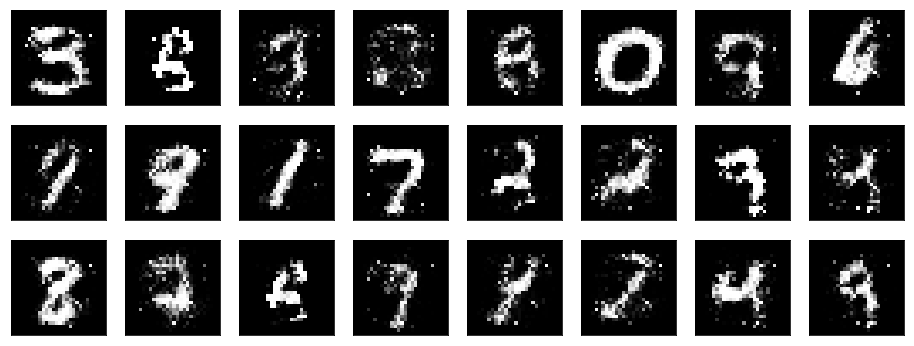

Epoch 121/400
 - 59s - g_loss: 1.6706 - d_loss: 0.6941 - d_acc: 0.6296
Epoch 122/400
 - 58s - g_loss: 1.8245 - d_loss: 0.6991 - d_acc: 0.6376
Epoch 123/400
 - 58s - g_loss: 1.8929 - d_loss: 0.6877 - d_acc: 0.6430
Epoch 124/400
 - 58s - g_loss: 1.6111 - d_loss: 0.7149 - d_acc: 0.6214
Epoch 125/400
 - 58s - g_loss: 1.6823 - d_loss: 0.7009 - d_acc: 0.6284
Epoch 126/400
 - 58s - g_loss: 1.7459 - d_loss: 0.7068 - d_acc: 0.6279
Epoch 127/400
 - 61s - g_loss: 1.5849 - d_loss: 0.7118 - d_acc: 0.6217
Epoch 128/400
 - 58s - g_loss: 1.9134 - d_loss: 0.7067 - d_acc: 0.6288
Epoch 129/400
 - 59s - g_loss: 1.2810 - d_loss: 0.6837 - d_acc: 0.6195
Epoch 130/400
 - 58s - g_loss: 1.6992 - d_loss: 0.7315 - d_acc: 0.6200
Epoch 131/400
 - 58s - g_loss: 1.7541 - d_loss: 0.7109 - d_acc: 0.6257
Epoch 132/400
 - 59s - g_loss: 1.3709 - d_loss: 0.6877 - d_acc: 0.6221
Epoch 133/400
 - 59s - g_loss: 1.5381 - d_loss: 0.6881 - d_acc: 0.6251
Epoch 134/400
 - 58s - g_loss: 1.6875 - d_loss: 0.7062 - d_acc: 0.6283
Epoch 

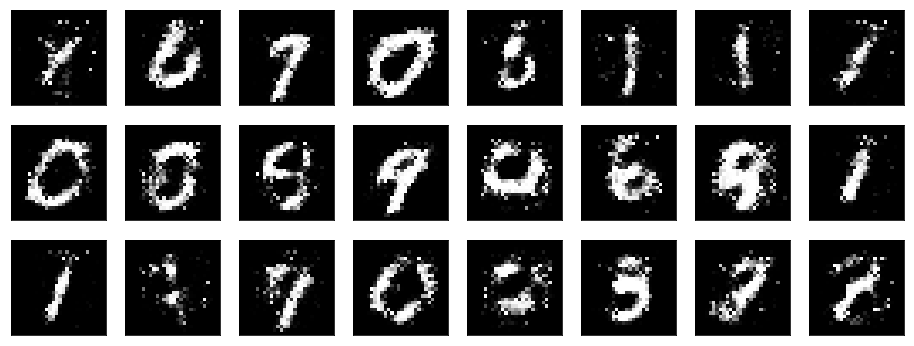

Epoch 141/400
 - 58s - g_loss: 1.4259 - d_loss: 0.7176 - d_acc: 0.6062
Epoch 142/400
 - 58s - g_loss: 1.4336 - d_loss: 0.6978 - d_acc: 0.6165
Epoch 143/400
 - 58s - g_loss: 1.5607 - d_loss: 0.7151 - d_acc: 0.6135
Epoch 144/400
 - 58s - g_loss: 1.6739 - d_loss: 0.6853 - d_acc: 0.6321
Epoch 145/400
 - 58s - g_loss: 1.5457 - d_loss: 0.7208 - d_acc: 0.6130
Epoch 146/400
 - 59s - g_loss: 1.5230 - d_loss: 0.7320 - d_acc: 0.6077
Epoch 147/400
 - 59s - g_loss: 1.4619 - d_loss: 0.7251 - d_acc: 0.6049
Epoch 148/400
 - 58s - g_loss: 1.5987 - d_loss: 0.7143 - d_acc: 0.6183
Epoch 149/400
 - 58s - g_loss: 1.6149 - d_loss: 0.7193 - d_acc: 0.6181
Epoch 150/400
 - 58s - g_loss: 1.6799 - d_loss: 0.7171 - d_acc: 0.6209
Epoch 151/400
 - 59s - g_loss: 1.4697 - d_loss: 0.7253 - d_acc: 0.6058
Epoch 152/400
 - 58s - g_loss: 1.7097 - d_loss: 0.7243 - d_acc: 0.6225
Epoch 153/400
 - 58s - g_loss: 1.4142 - d_loss: 0.7218 - d_acc: 0.6047
Epoch 154/400
 - 58s - g_loss: 1.6173 - d_loss: 0.7191 - d_acc: 0.6171
Epoch 

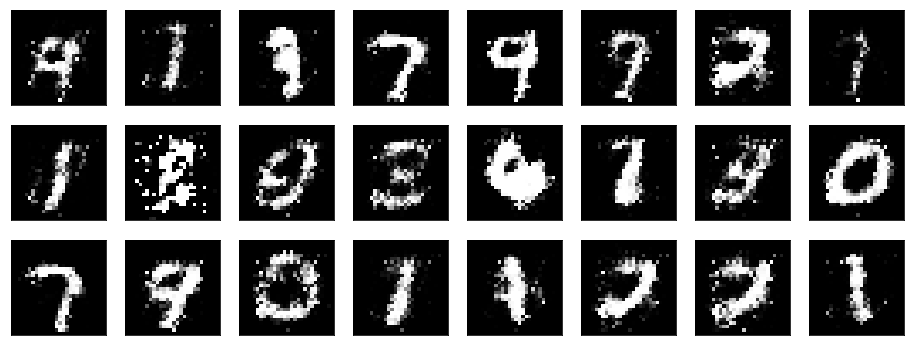

Epoch 161/400
 - 59s - g_loss: 1.4873 - d_loss: 0.7192 - d_acc: 0.6145
Epoch 162/400
 - 58s - g_loss: 1.4811 - d_loss: 0.7439 - d_acc: 0.6024
Epoch 163/400
 - 58s - g_loss: 1.5118 - d_loss: 0.7383 - d_acc: 0.6072
Epoch 164/400
 - 58s - g_loss: 1.5061 - d_loss: 0.7289 - d_acc: 0.6082
Epoch 165/400
 - 58s - g_loss: 1.4777 - d_loss: 0.7356 - d_acc: 0.6061
Epoch 166/400
 - 58s - g_loss: 1.5502 - d_loss: 0.7244 - d_acc: 0.6090
Epoch 167/400
 - 58s - g_loss: 1.5585 - d_loss: 0.7304 - d_acc: 0.6071
Epoch 168/400
 - 59s - g_loss: 1.4232 - d_loss: 0.7304 - d_acc: 0.6029
Epoch 169/400
 - 58s - g_loss: 1.5901 - d_loss: 0.7355 - d_acc: 0.6119
Epoch 170/400
 - 58s - g_loss: 1.3824 - d_loss: 0.7442 - d_acc: 0.5909
Epoch 171/400
 - 58s - g_loss: 1.5409 - d_loss: 0.7407 - d_acc: 0.6054
Epoch 172/400
 - 58s - g_loss: 1.2780 - d_loss: 0.7292 - d_acc: 0.5914
Epoch 173/400
 - 59s - g_loss: 1.5914 - d_loss: 0.7387 - d_acc: 0.6037
Epoch 174/400
 - 59s - g_loss: 1.3427 - d_loss: 0.7124 - d_acc: 0.6077
Epoch 

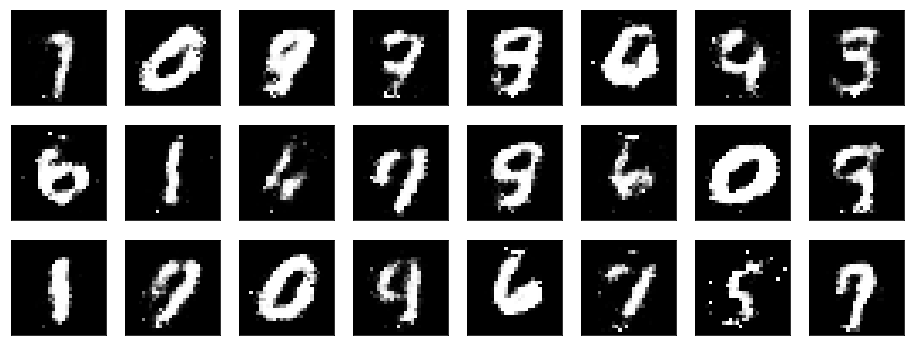

Epoch 181/400
 - 58s - g_loss: 1.4585 - d_loss: 0.7298 - d_acc: 0.6012
Epoch 182/400
 - 58s - g_loss: 1.2318 - d_loss: 0.7084 - d_acc: 0.6015
Epoch 183/400
 - 58s - g_loss: 1.4491 - d_loss: 0.7575 - d_acc: 0.5921
Epoch 184/400
 - 59s - g_loss: 1.4143 - d_loss: 0.7654 - d_acc: 0.5864
Epoch 185/400
 - 58s - g_loss: 1.5892 - d_loss: 0.7319 - d_acc: 0.6106
Epoch 186/400
 - 58s - g_loss: 1.4125 - d_loss: 0.7188 - d_acc: 0.6039
Epoch 187/400
 - 59s - g_loss: 1.4269 - d_loss: 0.7366 - d_acc: 0.5962
Epoch 188/400
 - 58s - g_loss: 1.5061 - d_loss: 0.7362 - d_acc: 0.6028
Epoch 189/400
 - 58s - g_loss: 1.2975 - d_loss: 0.7461 - d_acc: 0.5852
Epoch 190/400
 - 58s - g_loss: 1.3813 - d_loss: 0.7542 - d_acc: 0.5895
Epoch 191/400
 - 59s - g_loss: 1.2831 - d_loss: 0.7623 - d_acc: 0.5768
Epoch 192/400
 - 58s - g_loss: 1.4183 - d_loss: 0.7403 - d_acc: 0.5967
Epoch 193/400
 - 58s - g_loss: 1.4857 - d_loss: 0.7173 - d_acc: 0.6106
Epoch 194/400
 - 58s - g_loss: 1.3304 - d_loss: 0.7488 - d_acc: 0.5846
Epoch 

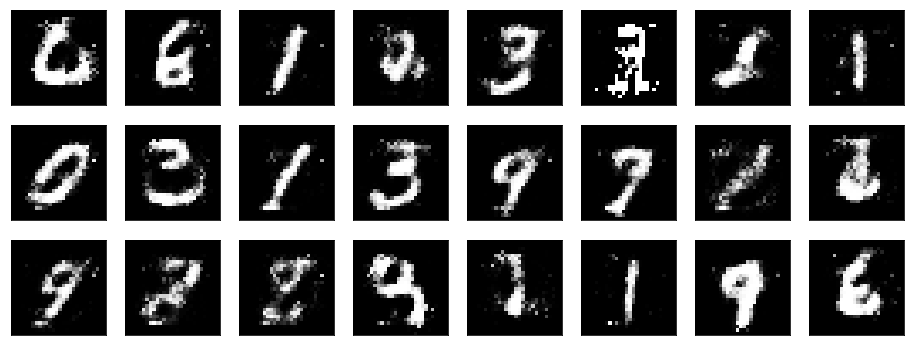

Epoch 201/400
 - 58s - g_loss: 1.3457 - d_loss: 0.7585 - d_acc: 0.5820
Epoch 202/400
 - 58s - g_loss: 1.4890 - d_loss: 0.7638 - d_acc: 0.5880
Epoch 203/400
 - 59s - g_loss: 1.3803 - d_loss: 0.7329 - d_acc: 0.6009
Epoch 204/400
 - 58s - g_loss: 1.3559 - d_loss: 0.7535 - d_acc: 0.5855
Epoch 205/400
 - 58s - g_loss: 1.6505 - d_loss: 0.7270 - d_acc: 0.6114
Epoch 206/400
 - 58s - g_loss: 1.3557 - d_loss: 0.7279 - d_acc: 0.5955
Epoch 207/400
 - 59s - g_loss: 1.3486 - d_loss: 0.7403 - d_acc: 0.5942
Epoch 208/400
 - 58s - g_loss: 1.3420 - d_loss: 0.7549 - d_acc: 0.5859
Epoch 209/400
 - 58s - g_loss: 1.2786 - d_loss: 0.7546 - d_acc: 0.5785
Epoch 210/400
 - 59s - g_loss: 1.5279 - d_loss: 0.7354 - d_acc: 0.5995
Epoch 211/400
 - 58s - g_loss: 1.3471 - d_loss: 0.7400 - d_acc: 0.5911
Epoch 212/400
 - 58s - g_loss: 1.3658 - d_loss: 0.7401 - d_acc: 0.5926
Epoch 213/400
 - 58s - g_loss: 1.3961 - d_loss: 0.7519 - d_acc: 0.5901
Epoch 214/400
 - 58s - g_loss: 1.4117 - d_loss: 0.7585 - d_acc: 0.5860
Epoch 

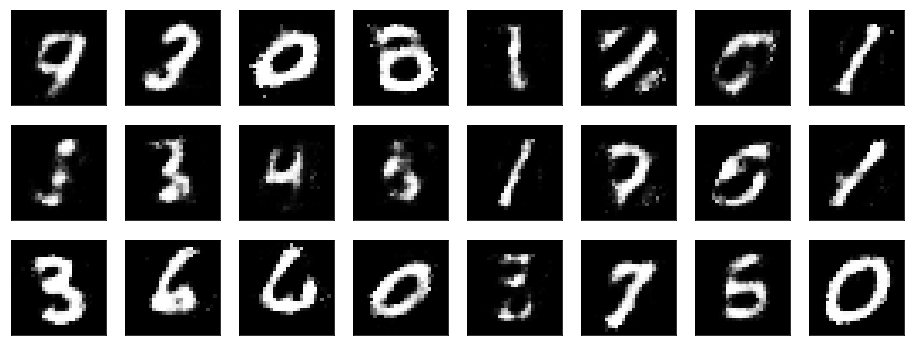

Epoch 221/400
 - 58s - g_loss: 1.4091 - d_loss: 0.7437 - d_acc: 0.5908
Epoch 222/400
 - 58s - g_loss: 1.3447 - d_loss: 0.7523 - d_acc: 0.5851
Epoch 223/400
 - 58s - g_loss: 1.2370 - d_loss: 0.7433 - d_acc: 0.5839
Epoch 224/400
 - 58s - g_loss: 1.2789 - d_loss: 0.7620 - d_acc: 0.5771
Epoch 225/400
 - 58s - g_loss: 1.2911 - d_loss: 0.7666 - d_acc: 0.5742
Epoch 226/400
 - 59s - g_loss: 1.2745 - d_loss: 0.7502 - d_acc: 0.5795
Epoch 227/400
 - 58s - g_loss: 1.3739 - d_loss: 0.7391 - d_acc: 0.5930
Epoch 228/400
 - 58s - g_loss: 1.4930 - d_loss: 0.7770 - d_acc: 0.5842
Epoch 229/400
 - 59s - g_loss: 1.3819 - d_loss: 0.7548 - d_acc: 0.5890
Epoch 230/400
 - 59s - g_loss: 1.3567 - d_loss: 0.7314 - d_acc: 0.5934
Epoch 231/400
 - 58s - g_loss: 1.3406 - d_loss: 0.7349 - d_acc: 0.5929
Epoch 232/400
 - 58s - g_loss: 1.3274 - d_loss: 0.7510 - d_acc: 0.5837
Epoch 233/400
 - 58s - g_loss: 1.2577 - d_loss: 0.7530 - d_acc: 0.5781
Epoch 234/400
 - 58s - g_loss: 1.4147 - d_loss: 0.7759 - d_acc: 0.5813
Epoch 

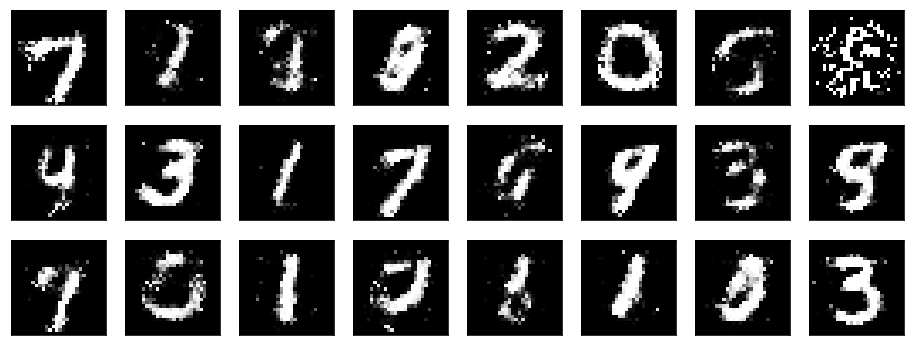

Epoch 241/400
 - 58s - g_loss: 1.2613 - d_loss: 0.7168 - d_acc: 0.5983
Epoch 242/400
 - 58s - g_loss: 1.3582 - d_loss: 0.7502 - d_acc: 0.5908
Epoch 243/400
 - 58s - g_loss: 1.3153 - d_loss: 0.7593 - d_acc: 0.5786
Epoch 244/400
 - 58s - g_loss: 1.2492 - d_loss: 0.7702 - d_acc: 0.5669
Epoch 245/400
 - 58s - g_loss: 1.3566 - d_loss: 0.7620 - d_acc: 0.5815
Epoch 246/400
 - 58s - g_loss: 1.2556 - d_loss: 0.7590 - d_acc: 0.5749
Epoch 247/400
 - 58s - g_loss: 1.2505 - d_loss: 0.7564 - d_acc: 0.5731
Epoch 248/400
 - 59s - g_loss: 1.3985 - d_loss: 0.7579 - d_acc: 0.5868
Epoch 249/400
 - 58s - g_loss: 1.3616 - d_loss: 0.7670 - d_acc: 0.5795
Epoch 250/400
 - 60s - g_loss: 1.4012 - d_loss: 0.7777 - d_acc: 0.5754
Epoch 251/400
 - 60s - g_loss: 1.4044 - d_loss: 0.7461 - d_acc: 0.5909
Epoch 252/400
 - 58s - g_loss: 1.3335 - d_loss: 0.7290 - d_acc: 0.5901
Epoch 253/400
 - 58s - g_loss: 1.2206 - d_loss: 0.7341 - d_acc: 0.5857
Epoch 254/400
 - 60s - g_loss: 1.2603 - d_loss: 0.7416 - d_acc: 0.5834
Epoch 

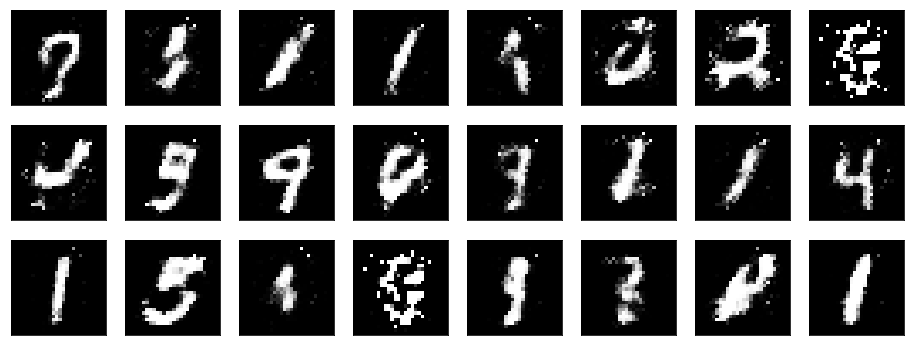

Epoch 261/400
 - 58s - g_loss: 1.4932 - d_loss: 0.7383 - d_acc: 0.5998
Epoch 262/400
 - 58s - g_loss: 1.0229 - d_loss: 0.7064 - d_acc: 0.5825
Epoch 263/400
 - 58s - g_loss: 1.4968 - d_loss: 0.7742 - d_acc: 0.5872
Epoch 264/400
 - 58s - g_loss: 1.2983 - d_loss: 0.7480 - d_acc: 0.5836
Epoch 265/400
 - 58s - g_loss: 1.3226 - d_loss: 0.7590 - d_acc: 0.5793
Epoch 266/400
 - 59s - g_loss: 1.3142 - d_loss: 0.7517 - d_acc: 0.5829
Epoch 267/400
 - 58s - g_loss: 1.3320 - d_loss: 0.7469 - d_acc: 0.5835
Epoch 268/400
 - 58s - g_loss: 1.2090 - d_loss: 0.7394 - d_acc: 0.5802
Epoch 269/400
 - 59s - g_loss: 1.2809 - d_loss: 0.7565 - d_acc: 0.5769
Epoch 270/400
 - 59s - g_loss: 1.3008 - d_loss: 0.7621 - d_acc: 0.5739
Epoch 271/400
 - 58s - g_loss: 1.2923 - d_loss: 0.7783 - d_acc: 0.5679
Epoch 272/400
 - 58s - g_loss: 1.3426 - d_loss: 0.7846 - d_acc: 0.5665
Epoch 273/400
 - 58s - g_loss: 1.2117 - d_loss: 0.7439 - d_acc: 0.5787
Epoch 274/400
 - 58s - g_loss: 1.2547 - d_loss: 0.7659 - d_acc: 0.5700
Epoch 

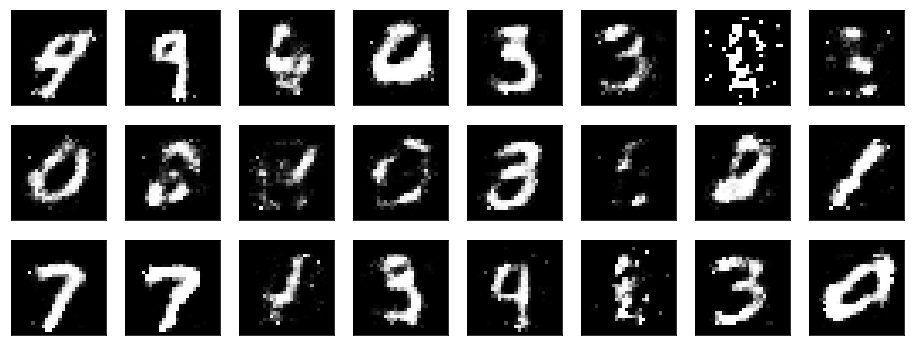

Epoch 281/400
 - 58s - g_loss: 1.1939 - d_loss: 0.7571 - d_acc: 0.5688
Epoch 282/400
 - 58s - g_loss: 1.3736 - d_loss: 0.7487 - d_acc: 0.5855
Epoch 283/400
 - 59s - g_loss: 1.2167 - d_loss: 0.7600 - d_acc: 0.5694
Epoch 284/400
 - 59s - g_loss: 1.2878 - d_loss: 0.7675 - d_acc: 0.5695
Epoch 285/400
 - 58s - g_loss: 1.2010 - d_loss: 0.7672 - d_acc: 0.5636
Epoch 286/400
 - 58s - g_loss: 1.2774 - d_loss: 0.7422 - d_acc: 0.5807
Epoch 287/400
 - 58s - g_loss: 1.2446 - d_loss: 0.7544 - d_acc: 0.5726
Epoch 288/400
 - 58s - g_loss: 1.3420 - d_loss: 0.7558 - d_acc: 0.5814
Epoch 289/400
 - 58s - g_loss: 1.3288 - d_loss: 0.7840 - d_acc: 0.5694
Epoch 290/400
 - 58s - g_loss: 1.1916 - d_loss: 0.7399 - d_acc: 0.5761
Epoch 291/400
 - 58s - g_loss: 1.2634 - d_loss: 0.7737 - d_acc: 0.5643
Epoch 292/400
 - 58s - g_loss: 1.2199 - d_loss: 0.7546 - d_acc: 0.5697
Epoch 293/400
 - 59s - g_loss: 1.3242 - d_loss: 0.7468 - d_acc: 0.5814
Epoch 294/400
 - 58s - g_loss: 1.3061 - d_loss: 0.7428 - d_acc: 0.5840
Epoch 

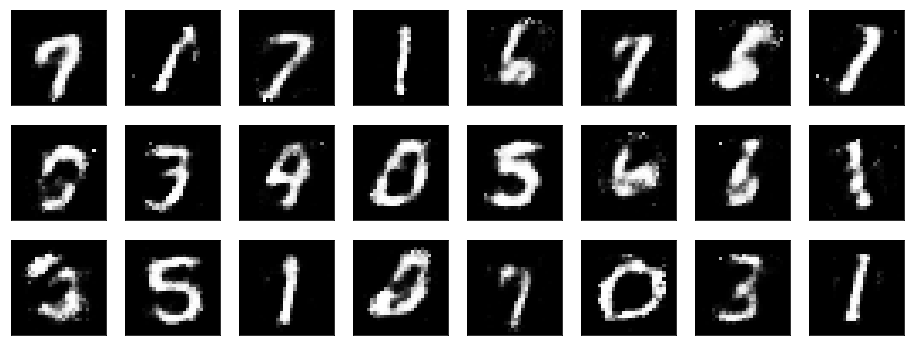

Epoch 301/400
 - 58s - g_loss: 1.3680 - d_loss: 0.7559 - d_acc: 0.5852
Epoch 302/400
 - 58s - g_loss: 1.2364 - d_loss: 0.7493 - d_acc: 0.5772
Epoch 303/400
 - 58s - g_loss: 1.3713 - d_loss: 0.7524 - d_acc: 0.5844
Epoch 304/400
 - 58s - g_loss: 1.2449 - d_loss: 0.7459 - d_acc: 0.5771
Epoch 305/400
 - 59s - g_loss: 1.1890 - d_loss: 0.7494 - d_acc: 0.5748
Epoch 306/400
 - 58s - g_loss: 1.3312 - d_loss: 0.7868 - d_acc: 0.5661
Epoch 307/400
 - 58s - g_loss: 1.2852 - d_loss: 0.7495 - d_acc: 0.5820
Epoch 308/400
 - 58s - g_loss: 1.2199 - d_loss: 0.7589 - d_acc: 0.5707
Epoch 309/400
 - 59s - g_loss: 1.2424 - d_loss: 0.7552 - d_acc: 0.5752
Epoch 310/400
 - 58s - g_loss: 1.2635 - d_loss: 0.7461 - d_acc: 0.5788
Epoch 311/400
 - 58s - g_loss: 1.2525 - d_loss: 0.7643 - d_acc: 0.5693
Epoch 312/400
 - 58s - g_loss: 1.2279 - d_loss: 0.7709 - d_acc: 0.5623
Epoch 313/400
 - 58s - g_loss: 1.2151 - d_loss: 0.7601 - d_acc: 0.5684
Epoch 314/400
 - 58s - g_loss: 1.3498 - d_loss: 0.7805 - d_acc: 0.5681
Epoch 

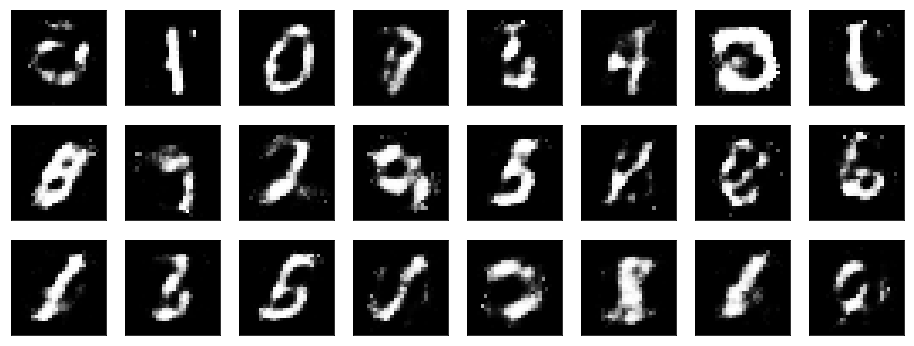

Epoch 321/400
 - 59s - g_loss: 1.1557 - d_loss: 0.7435 - d_acc: 0.5717
Epoch 322/400
 - 58s - g_loss: 1.2797 - d_loss: 0.7819 - d_acc: 0.5626
Epoch 323/400
 - 58s - g_loss: 1.3770 - d_loss: 0.7834 - d_acc: 0.5711
Epoch 324/400
 - 58s - g_loss: 1.1959 - d_loss: 0.7325 - d_acc: 0.5778
Epoch 325/400
 - 58s - g_loss: 1.2935 - d_loss: 0.7447 - d_acc: 0.5790
Epoch 326/400
 - 58s - g_loss: 1.2310 - d_loss: 0.7401 - d_acc: 0.5812
Epoch 327/400
 - 58s - g_loss: 1.2479 - d_loss: 0.7669 - d_acc: 0.5677
Epoch 328/400
 - 58s - g_loss: 1.2378 - d_loss: 0.7497 - d_acc: 0.5763
Epoch 329/400
 - 59s - g_loss: 1.1732 - d_loss: 0.7634 - d_acc: 0.5618
Epoch 330/400
 - 59s - g_loss: 1.2750 - d_loss: 0.7737 - d_acc: 0.5671
Epoch 331/400
 - 58s - g_loss: 1.1992 - d_loss: 0.7571 - d_acc: 0.5674
Epoch 332/400
 - 58s - g_loss: 1.2982 - d_loss: 0.7621 - d_acc: 0.5733
Epoch 333/400
 - 58s - g_loss: 1.1861 - d_loss: 0.7558 - d_acc: 0.5678
Epoch 334/400
 - 58s - g_loss: 1.1920 - d_loss: 0.7332 - d_acc: 0.5822
Epoch 

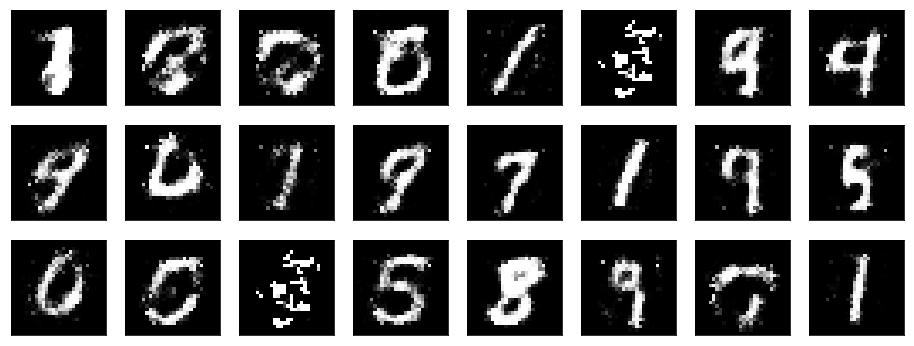

Epoch 341/400
 - 59s - g_loss: 1.1827 - d_loss: 0.7663 - d_acc: 0.5591
Epoch 342/400
 - 58s - g_loss: 1.2834 - d_loss: 0.7673 - d_acc: 0.5695
Epoch 343/400
 - 58s - g_loss: 1.3120 - d_loss: 0.7656 - d_acc: 0.5732
Epoch 344/400
 - 59s - g_loss: 1.1943 - d_loss: 0.7468 - d_acc: 0.5738
Epoch 345/400
 - 58s - g_loss: 1.2660 - d_loss: 0.7519 - d_acc: 0.5761
Epoch 346/400
 - 58s - g_loss: 1.1534 - d_loss: 0.7407 - d_acc: 0.5752
Epoch 347/400
 - 58s - g_loss: 1.2432 - d_loss: 0.7727 - d_acc: 0.5646
Epoch 348/400
 - 58s - g_loss: 1.2531 - d_loss: 0.7759 - d_acc: 0.5627
Epoch 349/400
 - 59s - g_loss: 1.3015 - d_loss: 0.7558 - d_acc: 0.5765
Epoch 350/400
 - 59s - g_loss: 1.1870 - d_loss: 0.7518 - d_acc: 0.5709
Epoch 351/400
 - 58s - g_loss: 1.2473 - d_loss: 0.7718 - d_acc: 0.5635
Epoch 352/400
 - 58s - g_loss: 1.2714 - d_loss: 0.7822 - d_acc: 0.5595
Epoch 353/400
 - 58s - g_loss: 1.1804 - d_loss: 0.7646 - d_acc: 0.5598
Epoch 354/400
 - 58s - g_loss: 1.3428 - d_loss: 0.7861 - d_acc: 0.5649
Epoch 

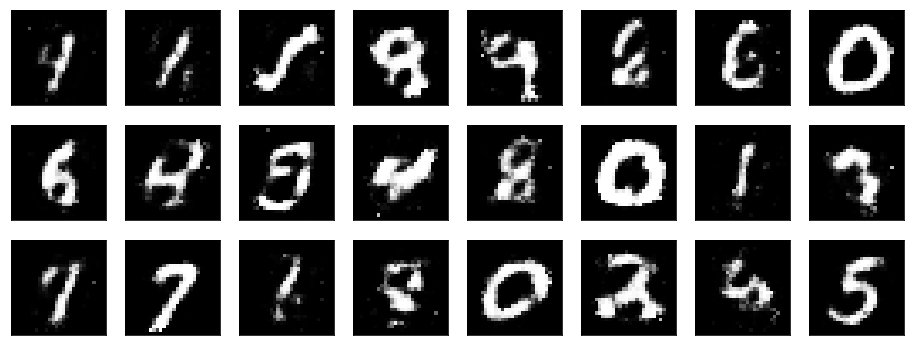

Epoch 361/400
 - 58s - g_loss: 1.1908 - d_loss: 0.7520 - d_acc: 0.5705
Epoch 362/400
 - 58s - g_loss: 1.1885 - d_loss: 0.7543 - d_acc: 0.5669
Epoch 363/400
 - 58s - g_loss: 1.2560 - d_loss: 0.7626 - d_acc: 0.5713
Epoch 364/400
 - 59s - g_loss: 1.1535 - d_loss: 0.7393 - d_acc: 0.5725
Epoch 365/400
 - 59s - g_loss: 1.2889 - d_loss: 0.7573 - d_acc: 0.5749
Epoch 366/400
 - 59s - g_loss: 1.2766 - d_loss: 0.7460 - d_acc: 0.5757
Epoch 367/400
 - 58s - g_loss: 1.1877 - d_loss: 0.7399 - d_acc: 0.5782
Epoch 368/400
 - 58s - g_loss: 1.2289 - d_loss: 0.7683 - d_acc: 0.5639
Epoch 369/400
 - 58s - g_loss: 1.3309 - d_loss: 0.7807 - d_acc: 0.5697
Epoch 370/400
 - 58s - g_loss: 1.1391 - d_loss: 0.7533 - d_acc: 0.5642
Epoch 371/400
 - 58s - g_loss: 1.2900 - d_loss: 0.7835 - d_acc: 0.5649
Epoch 372/400
 - 58s - g_loss: 1.2495 - d_loss: 0.7686 - d_acc: 0.5681
Epoch 373/400
 - 58s - g_loss: 1.1713 - d_loss: 0.7492 - d_acc: 0.5714
Epoch 374/400
 - 61s - g_loss: 1.1969 - d_loss: 0.7437 - d_acc: 0.5762
Epoch 

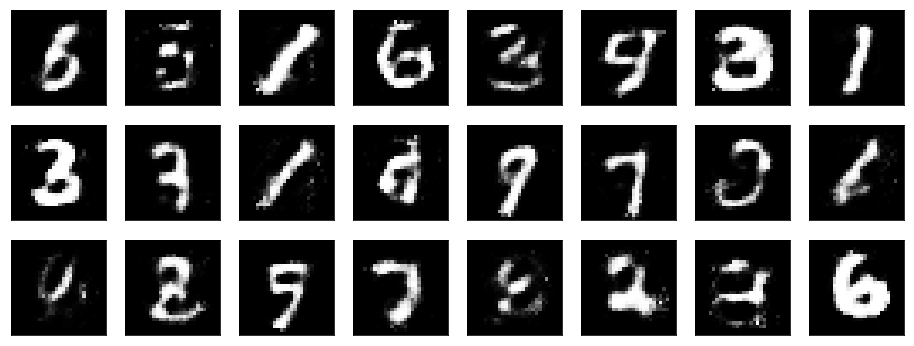

Epoch 381/400
 - 58s - g_loss: 1.1598 - d_loss: 0.7535 - d_acc: 0.5691
Epoch 382/400
 - 59s - g_loss: 1.1269 - d_loss: 0.7539 - d_acc: 0.5630
Epoch 383/400
 - 59s - g_loss: 1.2665 - d_loss: 0.7400 - d_acc: 0.5832
Epoch 384/400
 - 58s - g_loss: 1.2609 - d_loss: 0.7694 - d_acc: 0.5700
Epoch 385/400
 - 58s - g_loss: 1.2811 - d_loss: 0.7815 - d_acc: 0.5602
Epoch 386/400
 - 58s - g_loss: 1.1907 - d_loss: 0.7757 - d_acc: 0.5599
Epoch 387/400
 - 58s - g_loss: 1.3102 - d_loss: 0.7819 - d_acc: 0.5638
Epoch 388/400
 - 58s - g_loss: 1.3375 - d_loss: 0.7430 - d_acc: 0.5834
Epoch 389/400
 - 59s - g_loss: 1.0920 - d_loss: 0.7374 - d_acc: 0.5687
Epoch 390/400
 - 58s - g_loss: 1.2595 - d_loss: 0.7676 - d_acc: 0.5694
Epoch 391/400
 - 58s - g_loss: 1.2249 - d_loss: 0.7776 - d_acc: 0.5603
Epoch 392/400
 - 58s - g_loss: 1.1571 - d_loss: 0.7469 - d_acc: 0.5695
Epoch 393/400
 - 58s - g_loss: 1.1998 - d_loss: 0.7481 - d_acc: 0.5713
Epoch 394/400
 - 58s - g_loss: 1.2362 - d_loss: 0.7687 - d_acc: 0.5664
Epoch 

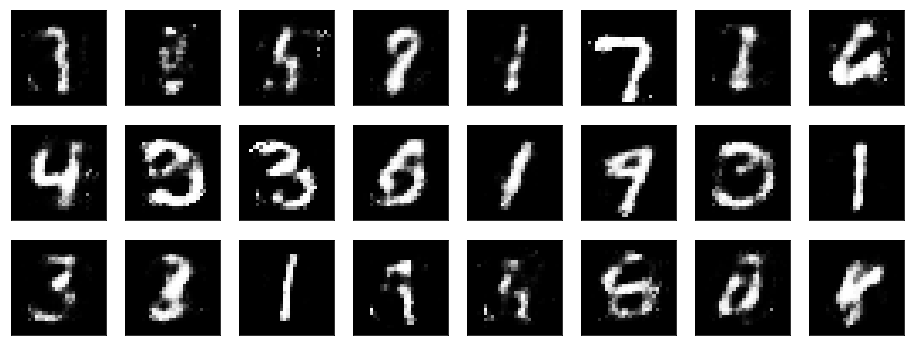

In [11]:
history = train(train_x, epochs=400, batch_size=50)

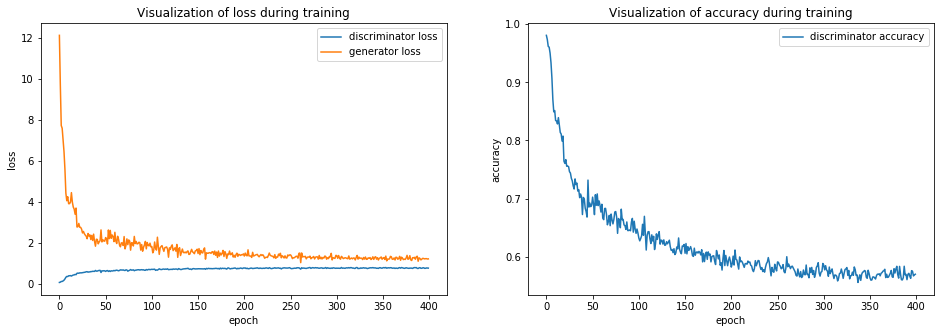

In [12]:
plot_history(history)